### Speech Rate

There are many ways to calculate speech rate. Here I am examining speech rate as a continuous variable characterising either words or phrases. Do not mistake phrases for speech turns!

<ol>
    <li>
    <b>Phrases</b>
    <br>In spontaneous speech, tempo might change tremendously inside a speech turn. However, it usualy varies little inside phrases (e.g. noun phrases, verb phrases). For this reason I split turns into phrases.
    <br>I've broken down the ways of looking at speech rate into positive and negative ones:
    <ul>
        <li style="margin-bottom: 10px;">
        <i>Positive</i>: speech rate/tempo as number of elements in segment / segment duration. 
        <br> Naming reason: when comparing element duration against speech rate, I get negative correlations
        </li>
        <li>
        <i>Negative</i>: speech rate/tempo as segment duration/number of elements in segment. 
        <br>Naming reason: when comparing element duration against speech rate, I get positive correlations
        </li>
    </ul>
    </li>
    <p></p>
<li><b>Words</b> breaking speech turns down to words is another way of avoiding too much rate variation inside the analised segment. </li>
</ol>

Elements: <br>
In the case of phrases I took both syllable count and phoneme count, in the case of words, only phoneme count, as most of them are usually < 4 syllable long in my database.

I start with importing the needed modules:

In [1]:
# Here I import all python modules needed
import new_SR
import model_utilities
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from collections import defaultdict

Here I define my static data:

In [2]:
# Here you may point to the dataset you wish to analyse. Just replace the string with your absolute path
dataset_path = model_utilities.get_path_list("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Training_neu")

# Path for saving pictures
fig_path = "C:/Users/alexutza_a/Abschlussarbeit/Grafiken/speech_rate/"

# List of evaluated phonemes. 
# As there are also other phonetic items segmented in our database, we use this list to sort those out.
# Example of excluded phonetic items: <p:>, <usb>
valid_phonemes = ["a", "a~", "e", "E", "I", "i", "O", "o", "U", "u", "Y", "y", "9", "2", "a:", "a~:", "e:", "E:", "i:",
                 "o:", "u:", "y:", "2:", "OY", "aU", "aI", "@", "6", "z", "S", "Z", "C", "x", "N", "Q", "b", "d", "f", 
                 "g", "h", "j", "k", "l", "m", "n", "p", "r", "s", "t", "v"]

# A dictionary of classes of phonemes to use later
ptype_dict = {"diphthong" : ["aU", "aI", "OY"], "long_vowels" : ["a:", "a~:", "e:", "E:", "i:", "o:", "u:", "y:", "2:"],
              "short_vowels" : ["a", "a~", "e", "E", "I", "i", "O", "o", "U", "u", "Y", "y", "9", "2"], "schwa" : ["@", "6"],
              "plosive" : ["b", "d", "p", "t", "k", "g"], "fricative" : ["f", "v", "s", "S", "z", "Z", "x", "h", "C"],
              "nasal" : ["m", "n", "N"], "lateral" : ["l"], "approximant" : ["j"], "other" : [ "Q", "r"]}

# A list of definitions for SR used
SR_namelist = ["(phrase_dur/phon_count): ", "(phrase_dur/syl_count): ", "(phon_count/phrase_dur): ", 
           "(syl_count/phrase_dur): ", "(word_duration/phon_count): ", "(phon_count/word_duration): "]

The following dictionary contains rather few features, as it is only meant for the above specified purpose.

In [3]:
# Create a dictionary of phoneme durations and speech rates
# @param dataset_path: a list of links to the files in selected dataset
# Looks like: {"short_vowels" : [dur1, p_phon_PSR1, p_syl_PSR1, n_phon_PSR1, n_syl_PSR1, p_phon_WSR1, n_phon_WSR1], 
#               "diphthongs" : [...], ...} 
def SR_dict(dataset_path):
    sr_d = defaultdict(list)
    for datei in dataset_path:
        work_file = open(datei)
        for line in work_file:
            if re.match("MAU", line) and str(line.split()[4]) in valid_phonemes:
                # Get the corresponding class of the current phoneme
                phon_type = [ key for key, value in ptype_dict.items() if str(line.split()[4]) in value][0]
                #print(str(datei)[-22:] + str(line.split()[3]) + str(line.split()[4]))
                # Append phoneme duration in msec to the corresponding class in dict
                sr_d[phon_type].append(round(int(line.split()[2]) * 0.0625, 2))
                
                # Get the corresponding phrase no. for current phoneme
                phrase_dict = new_SR.s_split_dict(new_SR.get_split_list(datei))
                #print(phrase_dict)
                if len(phrase_dict) > 0:
                    phrase_nr = [key for key,value in phrase_dict.items() if int(line.split()[3]) in value][0]
                else:
                    phrase_nr = 0

                # Calculate the corresponding speech rates for current phoneme
                p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR = new_SR.get_phrase_SR(datei, phrase_nr, phrase_dict)
                p_phon_WSR, n_phon_WSR = new_SR.get_word_SR(datei, int(line.split()[3]))
                
                # Append all above speech rates to the dict              
                sr_d[phon_type] += [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]
        work_file.close()
    return sr_d

In [4]:
# Calculate dictionary once, use it then many times ;)
%time speechrate_d = SR_dict(dataset_path)

Wall time: 11min 47s


In [5]:
# Get the lists for plotting
# @param my_dict: a dictionary, in this case the result of SR_dict(p)
# @param phon_class: a string = the class of phonemes for which you wish to generate the value lists (e.g. "diphthongs")
def list_generator(my_dict, phon_class):
    duration_list = my_dict[phon_class][::7]
    p_phon_PSR = my_dict[phon_class][1::7]
    p_syl_PSR = my_dict[phon_class][2::7]
    n_phon_PSR = my_dict[phon_class][3::7]
    n_syl_PSR = my_dict[phon_class][4::7]
    p_phon_WSR = my_dict[phon_class][5::7]
    n_phon_WSR = my_dict[phon_class][6::7]
    return duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR

##### Now we start plotting

1. Long vowels

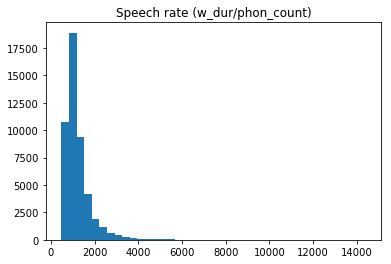

In [39]:
# Get all p_phon_WSR in one list together, to plot a histogram
SR_overview = []
for phon in speechrate_d.keys():
    SR_overview += speechrate_d[phon][5::7]

# Plot histogram of speech rate (word_duration / nr. of phonemes)
plt.hist(SR_overview, bins = 40)
plt.title("Speech rate (w_dur/phon_count)")
plt.show()

In [6]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "long_vowels")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Phoneme duration vs. SR (phrase_dur/phon_count): 0.641238355628
Phoneme duration vs. SR (phrase_dur/syl_count): 0.559734780554
Phoneme duration vs. SR (phon_count/phrase_dur): -0.468580852366
Phoneme duration vs. SR (syl_count/phrase_dur): -0.423966487058
Phoneme duration vs. SR (word_duration/phon_count): 0.824643640166
Phoneme duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


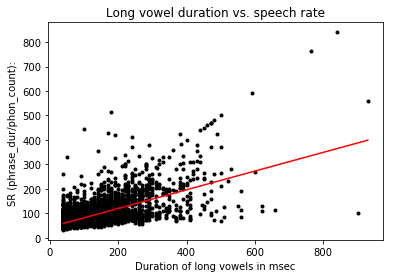

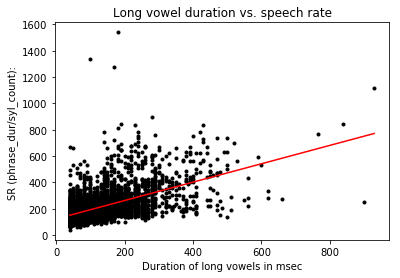

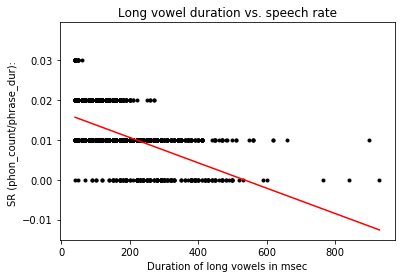

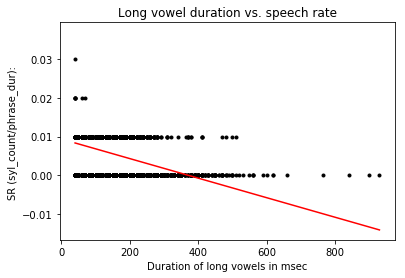

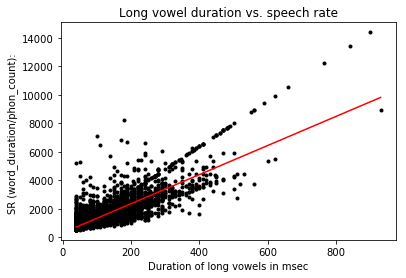

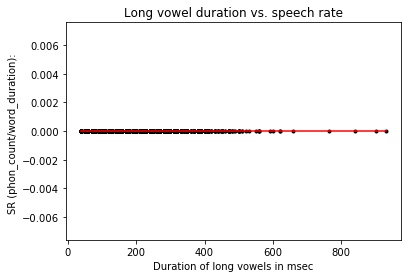

In [9]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Phoneme duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of long vowels in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Long vowel duration vs. speech rate")
    
    plt.savefig(fig_path + "SR" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

2 Diphthongs

In [14]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "diphthong")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]
print(len(duration_list))

1542


Pearson correlation coefficient (rho)
Diphthong duration vs. SR (phrase_dur/phon_count): 0.477171428219
Diphthong duration vs. SR (phrase_dur/syl_count): 0.378519668709
Diphthong duration vs. SR (phon_count/phrase_dur): -0.392075534121
Diphthong duration vs. SR (syl_count/phrase_dur): -0.338224630418
Diphthong duration vs. SR (word_duration/phon_count): 0.628966010749
Diphthong duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


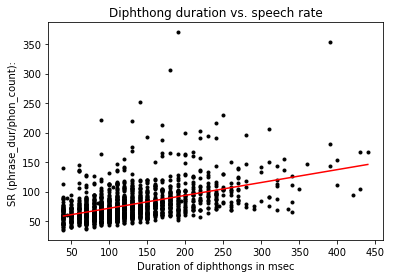

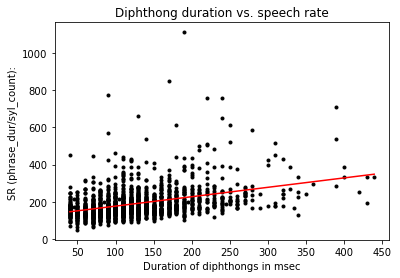

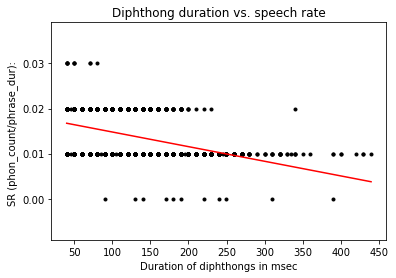

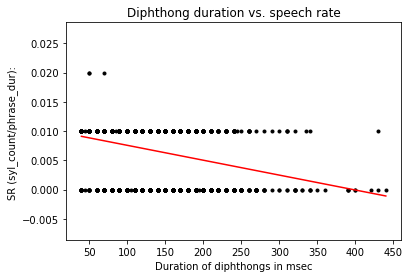

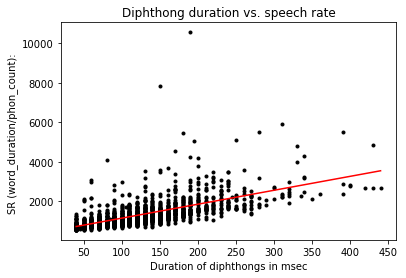

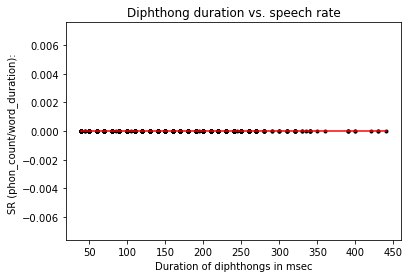

In [15]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Diphthong duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of diphthongs in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Diphthong duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_diph" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

3 Short vowels

In [16]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "diphthong")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Short vowel duration vs. SR (phrase_dur/phon_count): 0.477171428219
Short vowel duration vs. SR (phrase_dur/syl_count): 0.378519668709
Short vowel duration vs. SR (phon_count/phrase_dur): -0.392075534121
Short vowel duration vs. SR (syl_count/phrase_dur): -0.338224630418
Short vowel duration vs. SR (word_duration/phon_count): 0.628966010749
Short vowel duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


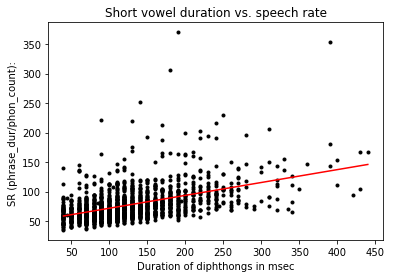

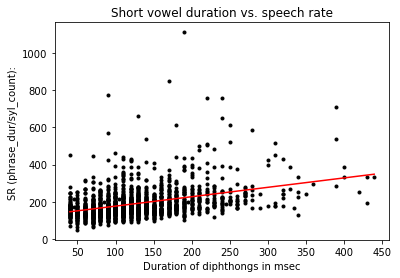

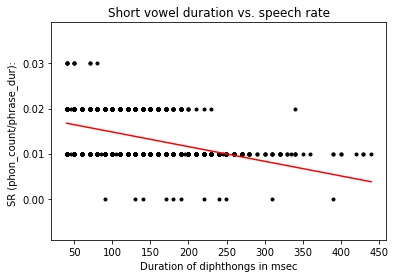

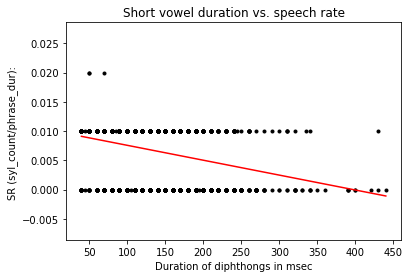

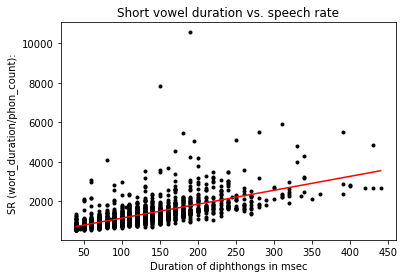

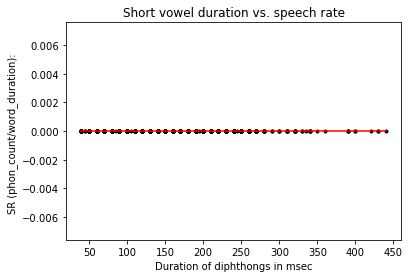

In [17]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Short vowel duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of diphthongs in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Short vowel duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_sv" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

4 Schwa

In [18]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "schwa")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Schwa duration vs. SR (phrase_dur/phon_count): 0.527519792601
Schwa duration vs. SR (phrase_dur/syl_count): 0.436260228617
Schwa duration vs. SR (phon_count/phrase_dur): -0.303545959834
Schwa duration vs. SR (syl_count/phrase_dur): -0.312339683773
Schwa duration vs. SR (word_duration/phon_count): 0.696649949525
Schwa duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


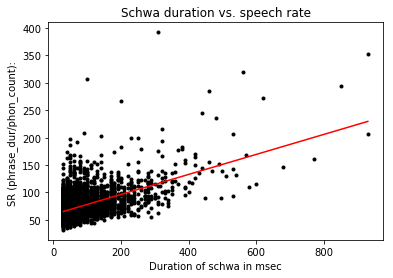

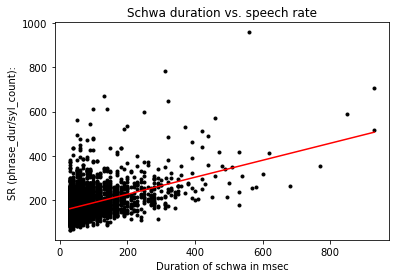

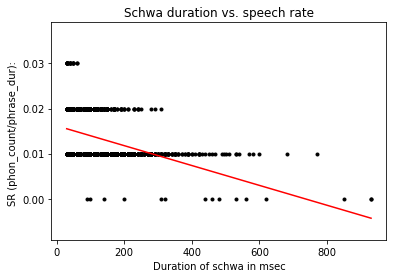

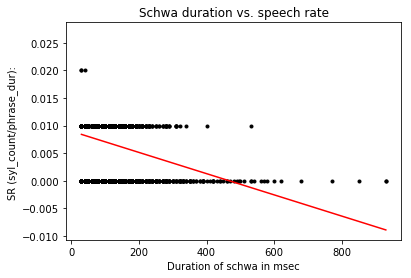

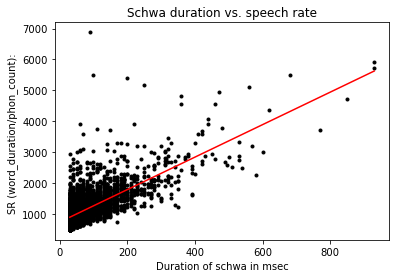

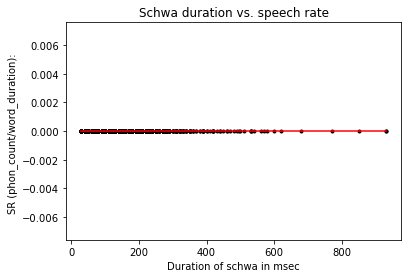

In [19]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Schwa duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of schwa in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Schwa duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_schwa" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

5 Plosives

In [20]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "plosive")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Plosive duration vs. SR (phrase_dur/phon_count): 0.513421863474
Plosive duration vs. SR (phrase_dur/syl_count): 0.503633037321
Plosive duration vs. SR (phon_count/phrase_dur): -0.244464766464
Plosive duration vs. SR (syl_count/phrase_dur): -0.201681959434
Plosive duration vs. SR (word_duration/phon_count): 0.606169506138
Plosive duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


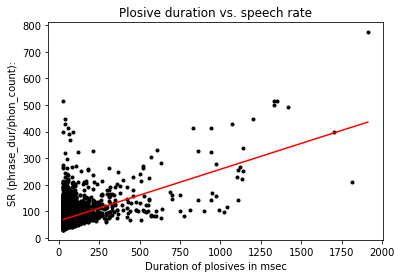

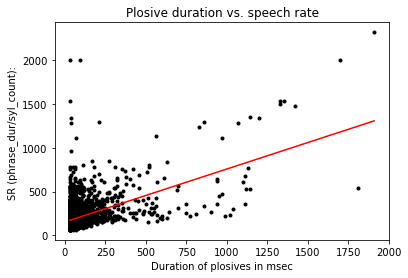

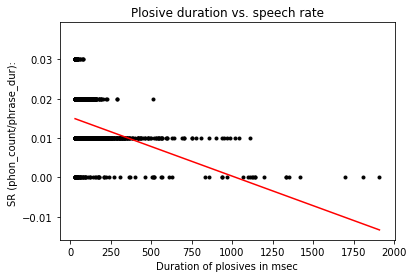

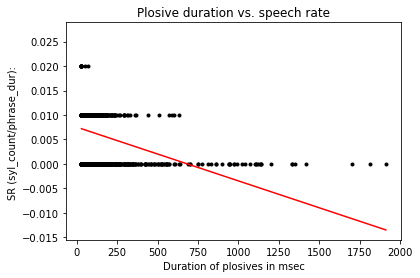

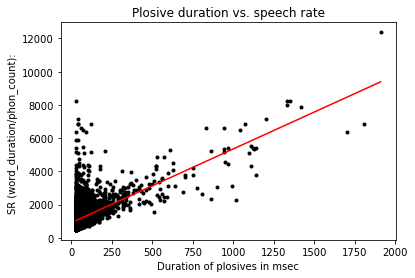

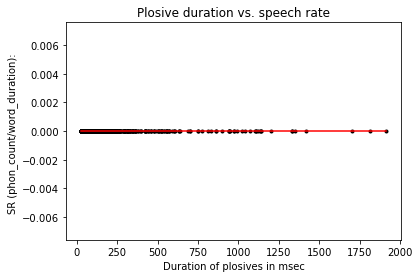

In [21]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Plosive duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of plosives in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Plosive duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_pl" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

6 Fricatives

In [26]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "fricative")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Fricative duration vs. SR (phrase_dur/phon_count): 0.435397023126
Fricative duration vs. SR (phrase_dur/syl_count): 0.400382189557
Fricative duration vs. SR (phon_count/phrase_dur): -0.272121279759
Fricative duration vs. SR (syl_count/phrase_dur): -0.257380665594
Fricative duration vs. SR (word_duration/phon_count): 0.648908322306
Fricative duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


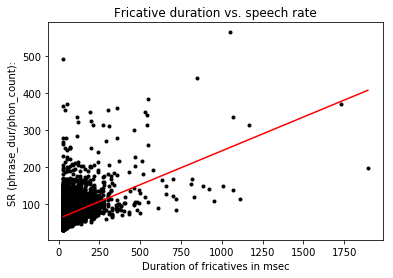

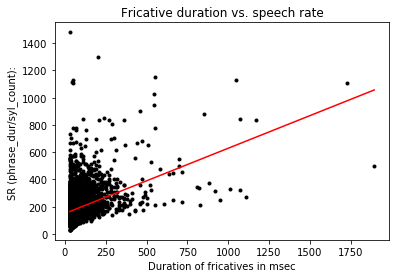

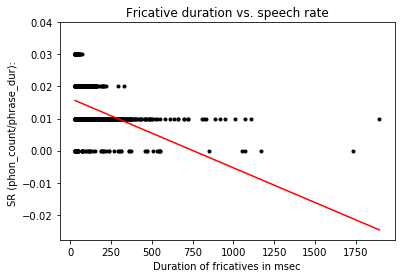

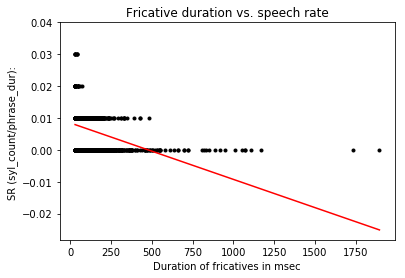

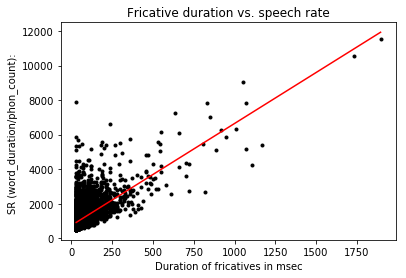

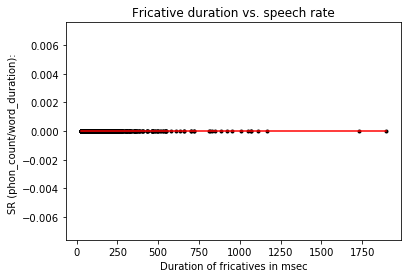

In [27]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Fricative duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of fricatives in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Fricative duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_fr" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

7 Nasals

In [28]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "nasal")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Nasal duration vs. SR (phrase_dur/phon_count): 0.562318523535
Nasal duration vs. SR (phrase_dur/syl_count): 0.520942788082
Nasal duration vs. SR (phon_count/phrase_dur): -0.375055962623
Nasal duration vs. SR (syl_count/phrase_dur): -0.352150396286
Nasal duration vs. SR (word_duration/phon_count): 0.668123155879
Nasal duration vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


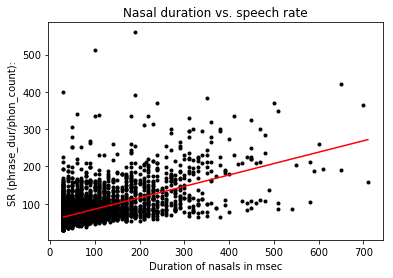

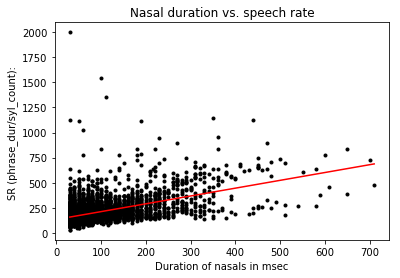

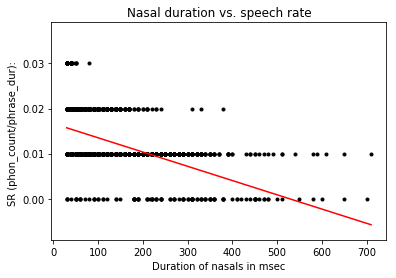

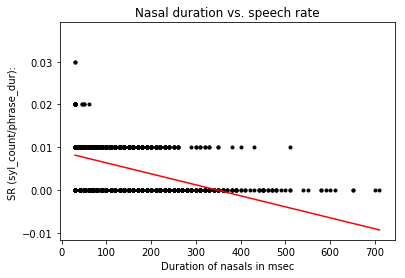

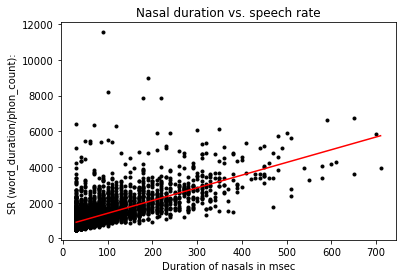

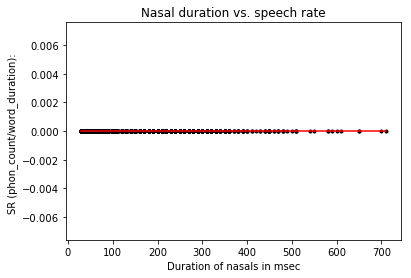

In [29]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Nasal duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of nasals in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Nasal duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_n" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

8 Lateral: /l/

In [30]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "lateral")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Duration of /l/ vs. SR (phrase_dur/phon_count): 0.415978703787
Duration of /l/ vs. SR (phrase_dur/syl_count): 0.409427157403
Duration of /l/ vs. SR (phon_count/phrase_dur): -0.27596156158
Duration of /l/ vs. SR (syl_count/phrase_dur): -0.300514878507
Duration of /l/ vs. SR (word_duration/phon_count): 0.558504535143
Duration of /l/ vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


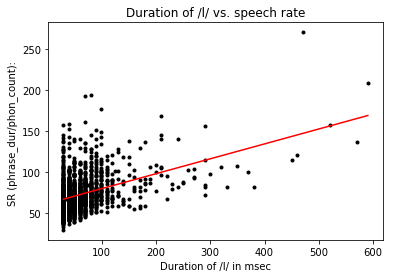

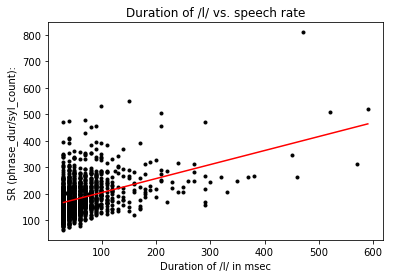

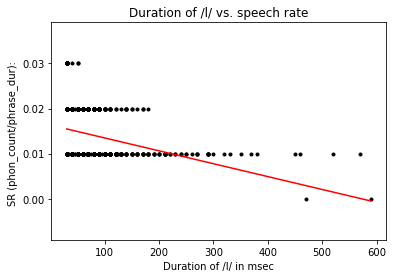

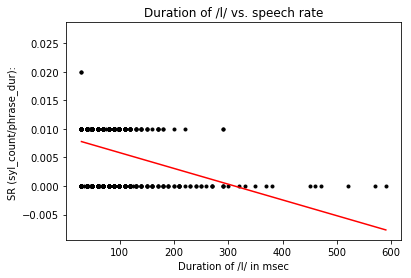

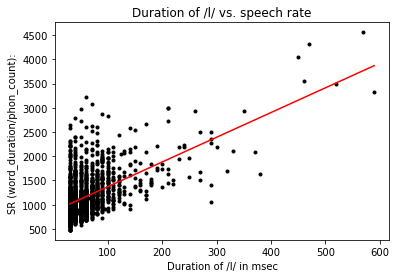

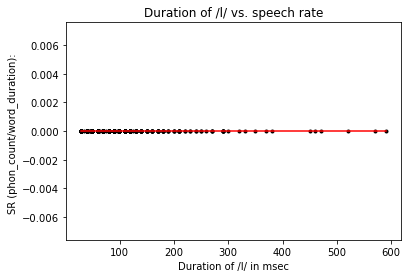

In [31]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Duration of /l/ vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of /l/ in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Duration of /l/ vs. speech rate")
    
    plt.savefig(fig_path + "SR_l" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

9 Approximant: /j/

In [32]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "approximant")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Duration of /j/ vs. SR (phrase_dur/phon_count): 0.56718620313
Duration of /j/ vs. SR (phrase_dur/syl_count): 0.471170832548
Duration of /j/ vs. SR (phon_count/phrase_dur): -0.509010093172
Duration of /j/ vs. SR (syl_count/phrase_dur): -0.385216432211
Duration of /j/ vs. SR (word_duration/phon_count): 0.625589717409
Duration of /j/ vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


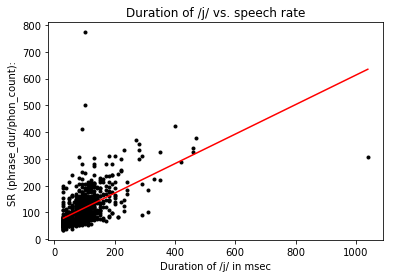

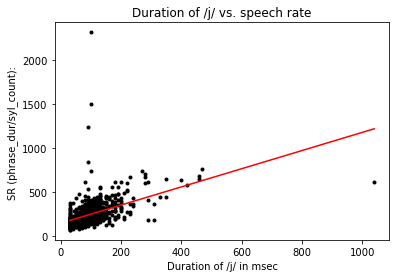

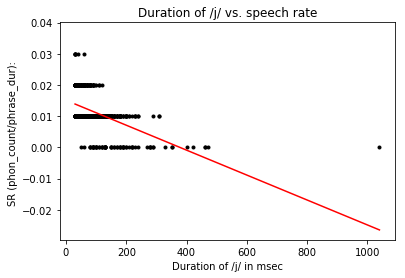

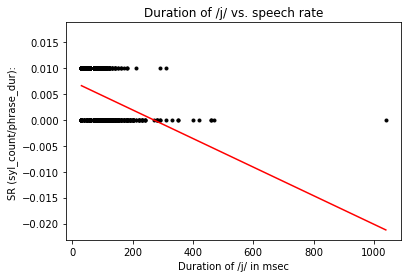

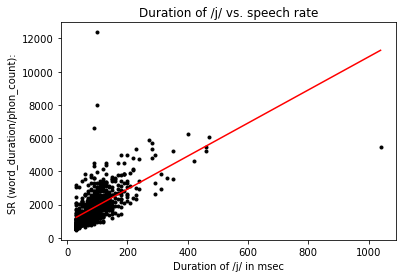

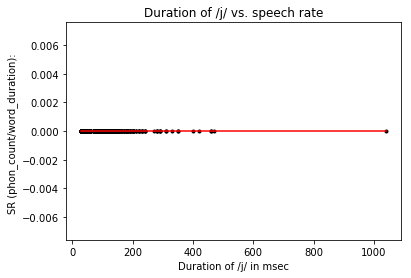

In [33]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Duration of /j/ vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of /j/ in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Duration of /j/ vs. speech rate")
    
    plt.savefig(fig_path + "SR_j" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

10 The extra shorts: /Q/ and /r/

In [34]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "other")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Duration of /Q/ and /r/ vs. SR (phrase_dur/phon_count): 0.198563711602
Duration of /Q/ and /r/ vs. SR (phrase_dur/syl_count): 0.190914176646
Duration of /Q/ and /r/ vs. SR (phon_count/phrase_dur): -0.14659651476
Duration of /Q/ and /r/ vs. SR (syl_count/phrase_dur): -0.177263439243
Duration of /Q/ and /r/ vs. SR (word_duration/phon_count): 0.259546005336
Duration of /Q/ and /r/ vs. SR (phon_count/word_duration): nan


C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\alexutza_a\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


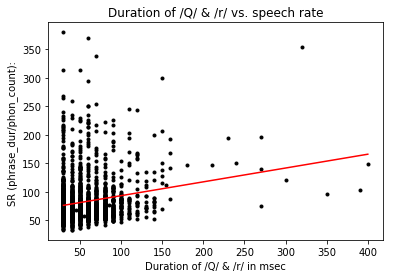

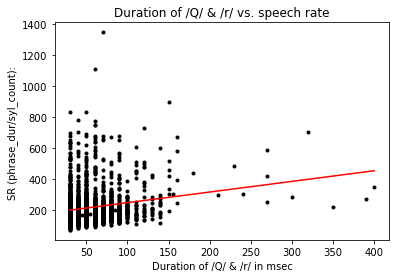

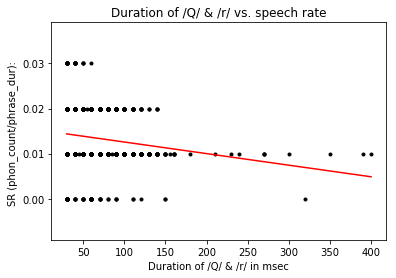

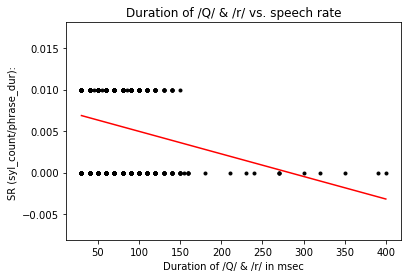

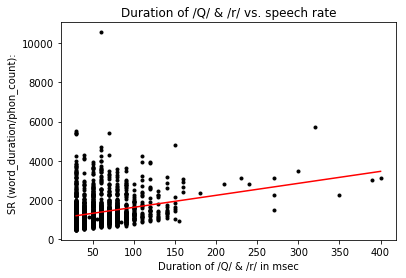

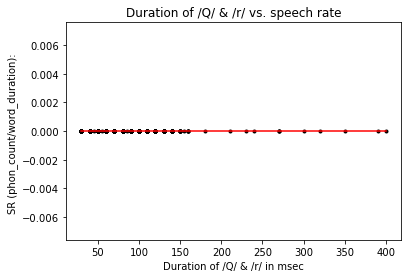

In [35]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Duration of /Q/ and /r/ vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of /Q/ & /r/ in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Duration of /Q/ & /r/ vs. speech rate")
    
    plt.savefig(fig_path + "SR_other" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()